In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

In [2]:
datadir = '..'
gatrain = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'),
                      index_col='device_id')
gatest = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'),
                     index_col = 'device_id')
phone = pd.read_csv(os.path.join(datadir,'phone_brand_device_model.csv'))
# Get rid of duplicate device ids in phone
phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id')
events = pd.read_csv(os.path.join(datadir,'events_subset.csv'),
                     parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv(os.path.join(datadir,'app_events_subset.csv'), 
                        usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
applabels = pd.read_csv(os.path.join(datadir,'app_labels_subset.csv'))

In [3]:
gatrain['trainrow'] = np.arange(gatrain.shape[0])
gatest['testrow'] = np.arange(gatest.shape[0])

In [4]:
brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])
gatrain['brand'] = phone['brand']
gatest['brand'] = phone['brand']
Xtr_brand = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.brand)))
Xte_brand = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.brand)))
print('Brand features: train shape {}, test shape {}'.format(Xtr_brand.shape, Xte_brand.shape))

Brand features: train shape (74645, 131), test shape (112071, 131)


In [25]:
print(np.max(phone.brand),np.max(phone.model))
phone.head

130 1666


<bound method NDFrame.head of                      phone_brand     device_model  brand  model
device_id                                                      
-8890648629457979026          小米               红米     51    858
 1277779817574759137          小米             MI 2     51    843
 5137427614288105724          三星        Galaxy S4     15    371
 3669464369358936369       SUGAR             时尚手机      9    166
-5019277647504317457          三星    Galaxy Note 2     15    347
 3238009352149731868          华为             Mate     31    671
-3883532755183027260          小米            MI 2S     51    846
-2972199645857147708          华为            G610S     31    648
-5827952925479472594          小米      MI One Plus     51    852
-8262508968076336275        vivo              S7I     13    214
 5840378295166286440          三星        Galaxy S3     15    368
-5776341595519925628          小米            MI 2A     51    844
 3437705102632680210          三星        Galaxy S3     15    368
-356833467

In [5]:
m = phone.phone_brand.str.cat(phone.device_model)
modelencoder = LabelEncoder().fit(m)
phone['model'] = modelencoder.transform(m)
gatrain['model'] = phone['model']
gatest['model'] = phone['model']
Xtr_model = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.model)))
Xte_model = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.model)))
print('Model features: train shape {}, test shape {}'.format(Xtr_model.shape, Xte_model.shape))

Model features: train shape (74645, 1667), test shape (112071, 1667)


In [6]:
appencoder = LabelEncoder().fit(appevents.app_id)
appevents['app'] = appencoder.transform(appevents.app_id)
napps = len(appencoder.classes_)
deviceapps = (appevents.merge(events[['device_id']], how='left',left_on='event_id',right_index=True)
                       .groupby(['device_id','app'])['app'].agg(['size'])
                       .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                       .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                       .reset_index())
deviceapps.head()

,device_id,app,size,trainrow,testrow
0,-9220329415676028483,61,1,NaN,83094
1,-9220329415676028483,166,1,NaN,83094
2,-9220329415676028483,183,1,NaN,83094
3,-9220329415676028483,476,1,NaN,83094
4,-9220329415676028483,615,1,NaN,83094


In [7]:
d = deviceapps.dropna(subset=['trainrow'])
Xtr_app = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.app)), 
                      shape=(gatrain.shape[0],napps))
d = deviceapps.dropna(subset=['testrow'])
Xte_app = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.app)), 
                      shape=(gatest.shape[0],napps))
print('Apps data: train shape {}, test shape {}'.format(Xtr_app.shape, Xte_app.shape))

Apps data: train shape (74645, 5504), test shape (112071, 5504)


In [8]:
applabels = applabels.loc[applabels.app_id.isin(appevents.app_id.unique())]
applabels['app'] = appencoder.transform(applabels.app_id)
labelencoder = LabelEncoder().fit(applabels.label_id)
applabels['label'] = labelencoder.transform(applabels.label_id)
nlabels = len(labelencoder.classes_)

In [9]:
devicelabels = (deviceapps[['device_id','app']]
                .merge(applabels[['app','label']])
                .groupby(['device_id','label'])['app'].agg(['size'])
                .merge(gatrain[['trainrow']], how='left', left_index=True, right_index=True)
                .merge(gatest[['testrow']], how='left', left_index=True, right_index=True)
                .reset_index())
devicelabels.head()

,device_id,label,size,trainrow,testrow
0,-9220329415676028483,0,1,NaN,83094
1,-9220329415676028483,12,8,NaN,83094
2,-9220329415676028483,13,31,NaN,83094
3,-9220329415676028483,20,3,NaN,83094
4,-9220329415676028483,22,3,NaN,83094


In [10]:
d = devicelabels.dropna(subset=['trainrow'])
Xtr_label = csr_matrix((np.ones(d.shape[0]), (d.trainrow, d.label)), 
                      shape=(gatrain.shape[0],nlabels))
d = devicelabels.dropna(subset=['testrow'])
Xte_label = csr_matrix((np.ones(d.shape[0]), (d.testrow, d.label)), 
                      shape=(gatest.shape[0],nlabels))
print('Labels data: train shape {}, test shape {}'.format(Xtr_label.shape, Xte_label.shape))

Labels data: train shape (74645, 30), test shape (112071, 30)


In [11]:
Xtrain = hstack((Xtr_brand, Xtr_model, Xtr_app, Xtr_label), format='csr')
Xtest =  hstack((Xte_brand, Xte_model, Xte_app, Xte_label), format='csr')
print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

All features: train shape (74645, 7332), test shape (112071, 7332)


In [12]:
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [13]:
def score(clf, random_state = 0):
    kf = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        return log_loss(yte, pred[itest, :])
        print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
    print('')
    return log_loss(y, pred)

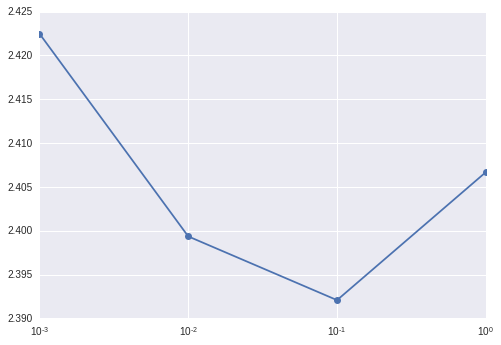

In [14]:
Cs = np.logspace(-3,0,4)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C)))
plt.semilogx(Cs, res,'-o');

In [15]:
score(LogisticRegression(C=0.02))

2.3960927513944168

In [16]:
clf = LogisticRegression(C=0.02, multi_class='multinomial',solver='lbfgs')
clf.fit(Xtrain, y)
pred = pd.DataFrame(clf.predict_proba(Xtest), index = gatest.index, columns=targetencoder.classes_)
pred.head()

,F23-,F24-26,F27-28,F29-32,F33-42,F43+,M22-,M23-26,M27-28,M29-31,M32-38,M39+
device_id,,,,,,,,,,,,
1002079943728939269,0.048425,0.054211,0.048074,0.062302,0.062072,0.050612,0.110474,0.154368,0.086057,0.101091,0.125335,0.096980
-1547860181818787117,0.049154,0.050907,0.042537,0.049722,0.060525,0.055544,0.100910,0.150901,0.079551,0.104124,0.131345,0.124780
7374582448058474277,0.050983,0.044571,0.034040,0.057697,0.085255,0.060924,0.080322,0.115715,0.070647,0.106860,0.145422,0.147565
-6220210354783429585,0.045871,0.050323,0.030296,0.058017,0.073379,0.056301,0.079781,0.146809,0.078471,0.115130,0.148457,0.117164
-5893464122623104785,0.045344,0.061370,0.042611,0.062047,0.057447,0.046417,0.083700,0.157953,0.094920,0.105024,0.142804,0.100364


In [17]:
pred.to_csv('logreg_subm.csv')